Implementation of the Ensemble Square Root Filter (EnSRS) based off the paper by [Whitaker and Compo (2002)](https://ams.confex.com/ams/pdfpapers/28864.pdf).

## Simulate Data

In [5]:
import numpy as np
import matplotlib.pyplot as plt

import importlib
import sys
sys.path.append('../src')
import simulate_data
importlib.reload(simulate_data)

true_params = {
    'rt_0': 1.4,
    'rt_1': 3.,
    'midpoint': 100.,
    'k': 0.1,
    'n_t': 365,
    't_I': 4.,
    'N': 100_000.,
    'S0': 99_900.,
    'I0': 100.,
}

np.random.seed(1994)
data = simulate_data.simulate_data(**true_params, add_noise=True, noise_param=1/50)

# Step 1 Perform EnSRF

In [6]:
def ensrf(x, y, z, oev, uhh=True):
    """
    Args:
        xhat: latent states or parameters
        H: observation operator
        y: Hx
        z: observation
        oev: observational error variance
    """
    H = np.array([0,0,0,1])
    x = np.array(x)
    y = np.array(y)

    xbar_hat = np.mean(x, axis=1)
    ybar_hat = np.mean(y)
    
    Pb = np.cov(x)
    Pyy = np.cov(y)
    if uhh:
        K = Pb@H.T/(Pyy + oev)  # eq 2
    else:
        Pb = np.cov(x,y)
        H = np.array([0,0,1])
        K = Pb@H.T/(Pyy + oev)  # eq 2
        K = K[:-1]
    xbar_a = xbar_hat + K*(np.mean(z) - ybar_hat)  # eq 4
    Ktilde = 1/(1 + np.sqrt(oev/(Pyy + oev)))*K    # eq 7
    Ktilde = np.array([Ktilde]).T
    inn = np.array([ybar_hat - y])
    xpost = x - np.array([xbar_hat]).T + np.array([xbar_a]).T + Ktilde@inn  # eq 5
    
    return xpost


In [7]:
import collections

SIR = collections.namedtuple(
  typename='SIRComponents',
  field_names=[
    'S',              # S
    'I',               # I
    'R',                # R
    'i'])

ModelParams = collections.namedtuple(
    typename='ModelParams',
    field_names=[
      'beta',                        # Beta
      't_I'   # t_I = 1/gamma
    ]
)

def f(t, x, θ, N, dt=1, noise_param=1/25):
    """
    State transition function.
        Args:
            t: time
            x: state space
            θ: parameters
            N: population
            dt: time step in days
    """

    # Stochastic transitions
    dSI = np.random.poisson(x.S * x.I/ N * θ.beta) # susceptible to infected
    dIR = np.random.poisson(x.I / θ.t_I) # infected to recovered
    
    # OEV = np.maximum(1., dSI**2 * noise_param)
    # OEV_sample= np.random.normal(0, 1, size=len(dSI))
    # i_noise = dSI + OEV_sample * np.sqrt(OEV)

    # Updates
    x_new = SIR(
        S = np.clip(x.S - dSI, 0, N),
        I = np.clip(x.I + dSI - dIR, 0, N),
        R = np.clip(x.R + dIR, 0, N),
        i = np.clip(dSI, 0, N)
    )

    return x_new

def g(x):
    """
    Observational function.
        Args:
            x: state space
            α: report rate
    """
    return x.i

def f0(pop, m=300):
    """
    Initial guess of the state space.
        Args:
            pop: population
            m: number of ensemble members
    """

    S0 = np.random.uniform(pop*0.8, pop, size=m)
    I0 = pop - S0
    R0 = np.zeros(m)
    i0 = np.zeros(m)
    
    x0 = SIR(
        S = S0,
        I = I0,
        R = R0,
        i = i0
    )
    return x0

def θ0(prior, m=300):
    """
    Initial guess of the parameter space.
        Args:
            prior: prior
            m: number of ensemble members
    """
    beta = prior['beta']['dist'](**prior['beta']['args'], size=m)
    θ0 = ModelParams(beta=beta, t_I=np.ones(m)*data.t_I)
    return θ0

In [8]:
from numpy.random import uniform

prior = {
    'beta':{
        'dist': uniform,
        'args':{
            'low': 0.1,
            'high': 2.,
        }
    },
    't_I':{
        'dist': "constant",
        # 'args':{
        #     'lower': 1.,
        #     'upper': 12.,
        # }
    },
}



In [9]:
from tqdm import tqdm

x_list = []
xhat_list = []
θ_list = []

for t, date in enumerate(range(data.n_t)):
    if t == 0:
        x = f0(data.N)
        θ = θ0(prior)
        xhat_list.append(x)
    else:
        x = f(t, x, θ, data.N)  # prediction
        xhat_list.append(x)
        y = g(x)
        z = data.i[t]
        
        oev = np.maximum(10, z**2/50)
        x = ensrf(x, y, z, oev=oev)
        x = np.clip(x, 0, data.N)
        x = SIR(*x)
        θ = ensrf(θ, y, z, oev=oev, uhh=False)
        θ = np.clip(θ, 0, None)
        θ = ModelParams(*θ)
    
    x_list.append(x)
    θ_list.append(θ)

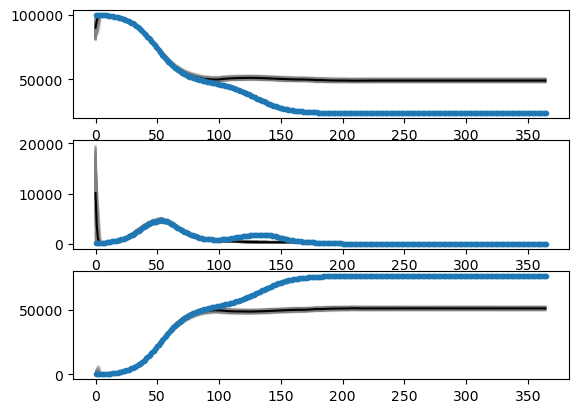

In [10]:
fig, ax = plt.subplots(3)
ax[0].plot([x.S for x in x_list], color='gray', alpha=0.1)
ax[0].plot(np.mean([x.S for x in x_list], axis=1), color='black')
ax[0].plot(data.S, '.')

ax[1].plot([x.I for x in x_list], color='gray', alpha=0.1)
ax[1].plot(np.mean([x.I for x in x_list], axis=1), color='black')
ax[1].plot(data.I, '.')

ax[2].plot([x.R for x in x_list], color='gray', alpha=0.1)
ax[2].plot(np.mean([x.R for x in x_list], axis=1), color='black')
ax[2].plot(data.R, '.')

Text(0.5, 0.98, 'EnSRS full time series no inflation')

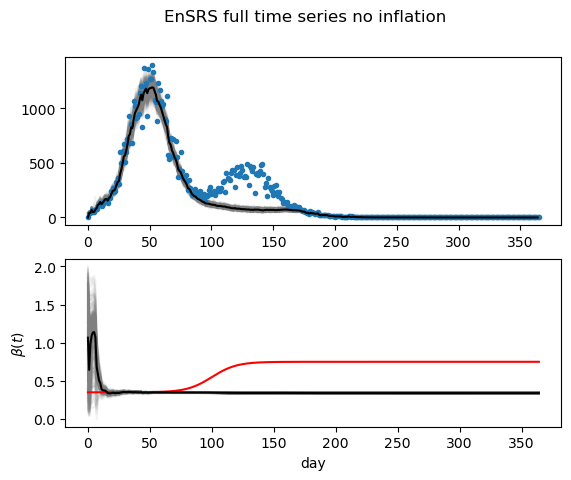

In [11]:
fig, ax = plt.subplots(2)
ax[0].plot([x.i for x in x_list], color='gray', alpha=0.1)
ax[0].plot(data.i, '.')
ax[0].plot(np.mean([x.i for x in x_list], axis=1), color='black')

ax[1].plot([θ.beta for θ in θ_list], color="gray", alpha=0.1)
ax[1].plot(data.construct_beta(data.rt, data.t_I), color="red")
ax[1].plot(np.mean([θ.beta for θ in θ_list], axis=1), color="black")
ax[1].set_xlabel('day')
ax[1].set_ylabel(r'$\beta(t)$')

fig.suptitle('EnSRS full time series no inflation')

In [12]:
def inflate_ensembles(ens, inflation_value=1.2):
    _, m = np.asarray(ens).shape
    ens_mean = np.mean(ens, 1, keepdims=True)
    return ens_mean * np.ones((1,m)) + inflation_value*(ens - ens_mean*np.ones((1,m)))

In [13]:
from tqdm import tqdm

x_list = []
xhat_list = []
θ_list = []
xhat_list = []

for t, date in enumerate(range(data.n_t)):
    if t == 0:
        x = f0(data.N)
        xhat_list.append(x)
        θ = θ0(prior)
    else:
        if (50 < t) & (t < 200) & (t % 2 == 0):
            θ = inflate_ensembles(θ, inflation_value=1.2)
            θ = np.clip(θ, 0, 10)
            θ = ModelParams(*θ)
        x = f(t, x, θ, data.N)  # prediction
        xhat_list.append(x)
        y = g(x)
        z = data.i[t]
        
        oev = np.maximum(10, z**2/50)
        x = ensrf(x, y, z, oev=oev)
        x = np.clip(x, 0, data.N)
        x = SIR(*x)
        θ = ensrf(θ, y, z, oev=oev, uhh=False)
        θ = np.clip(θ, 0, None)
        θ = ModelParams(*θ)
    
    x_list.append(x)
    θ_list.append(θ)

Text(0.5, 0.98, 'EnSRS full time series no inflation')

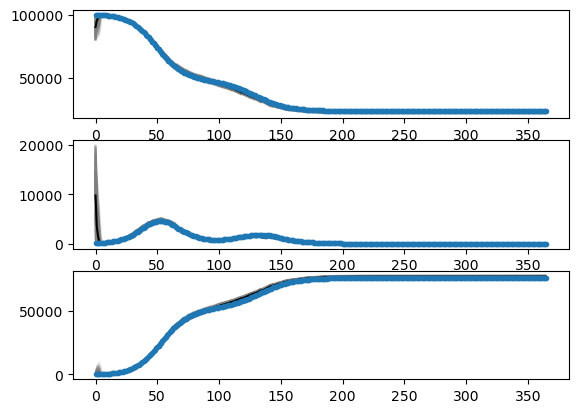

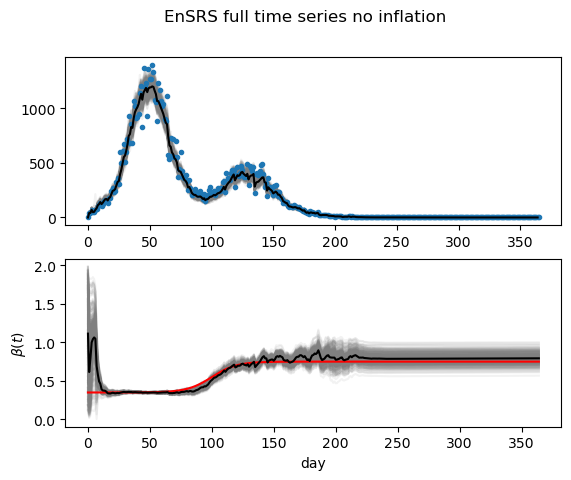

In [14]:
fig, ax = plt.subplots(3)
ax[0].plot([x.S for x in x_list], color='gray', alpha=0.1)
ax[0].plot(np.mean([x.S for x in x_list], axis=1), color='black')
ax[0].plot(data.S, '.')

ax[1].plot([x.I for x in x_list], color='gray', alpha=0.1)
ax[1].plot(np.mean([x.I for x in x_list], axis=1), color='black')
ax[1].plot(data.I, '.')

ax[2].plot([x.R for x in x_list], color='gray', alpha=0.1)
ax[2].plot(np.mean([x.R for x in x_list], axis=1), color='black')
ax[2].plot(data.R, '.')

fig, ax = plt.subplots(2)
ax[0].plot([x.i for x in x_list], color='gray', alpha=0.1)
ax[0].plot(data.i, '.')
ax[0].plot(np.mean([x.i for x in x_list], axis=1), color='black')

ax[1].plot([θ.beta for θ in θ_list], color="gray", alpha=0.1)
ax[1].plot(data.construct_beta(data.rt, data.t_I), color="red")
ax[1].plot(np.mean([θ.beta for θ in θ_list], axis=1), color="black")
ax[1].set_xlabel('day')
ax[1].set_ylabel(r'$\beta(t)$')

fig.suptitle('EnSRS full time series no inflation')

Text(0, 0.5, '$\\beta(t)$')

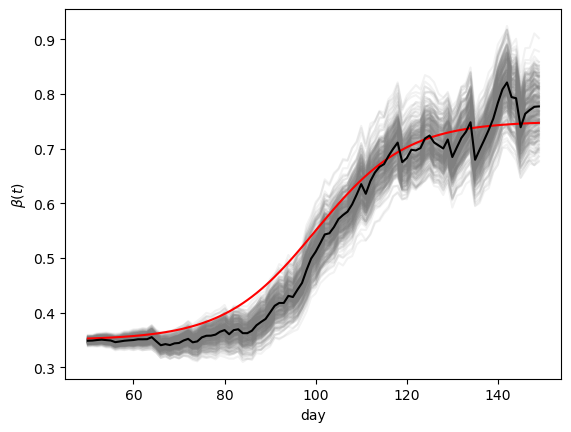

In [12]:
fig, ax = plt.subplots()
tt = np.arange(50, 150)
ens = np.array([θ.beta for θ in θ_list])
ax.plot(tt, ens[50:150,:], color="gray", alpha=0.1)
ax.plot(tt, data.construct_beta(data.rt, data.t_I)[50:150], color="red")
ax.plot(tt, np.mean([θ.beta for θ in θ_list], axis=1)[50:150], color="black")
ax.set_xlabel('day')
ax.set_ylabel(r'$\beta(t)$')

In [13]:
first_x_list = np.asarray(x_list).copy
first_θ_list = np.asarray(θ_list).copy()

In [14]:
beta = data.construct_beta(data.rt, data.t_I)

print(f"true midpoint: day {np.argmin(np.abs(beta - 0.55))}")
print(f"ensemble midpoint: day {np.argmin(np.abs(np.mean([θ.beta for θ in θ_list], axis=1) - 0.55))}")

true midpoint: day 100
ensemble midpoint: day 103


# Step 2 lag=1 smooth

In [15]:
x_list = np.array(x_list)
xhat_list = np.array(xhat_list)
θ_list = np.array(θ_list)

In [16]:
l = 1
x_lag_list = []
θ_lag_list = []

for k in range(data.n_t-1):
    z = data.i[k+l]
    oev = np.maximum(10, z**2/50)
    H = np.array([0,0,0,1])

    ## Smooth STATES
    x = x_list[k,:,:]
    xhat = xhat_list[k+l,:,:]
        
    y = H@xhat
    ybar_hat = np.mean(y)
    Pyy = np.cov(y)
    Pb = np.cov(xhat)
    Pba = np.cov(x, xhat)[4:,4:]
    # Pba = (x - np.array([x_bar]).T)@(H@(xhat - np.array([xhat_bar]).T)).T
    # eq 9
    K_lag = (H@Pba).T/(Pyy+oev)
    
    x_bar = np.mean(x, axis=1)
    xhat_bar = np.array([np.mean(xhat, axis=1)])
    # eq 8
    xbar_lag = x_bar + K_lag*(z - ybar_hat)
    # eq 15
    Ktilde_lag = K_lag/(1. + np.sqrt(oev/(Pyy + oev)))
    # eq 13
    x_lag = (x - np.array([x_bar]).T) + np.array([xbar_lag]).T - Ktilde_lag*H@(xhat - xhat_bar.T)
    
    x_lag = np.clip(x_lag, 0, data.N)
    x_lag = SIR(*x_lag)
    x_lag_list.append(x_lag)
    
    
    ## Smooth PARAMS
    θ = θ_list[k,:,:]
    Pb = np.cov(θ,y)
    H = np.array([0,0,1])
    Pba = np.cov(θ,y)
    
    # eq 9
    K_lag = (H@Pba).T/(Pyy+oev)
    K_lag = K_lag[:-1]
    
    θ_bar = np.array([np.mean(θ, axis=1)]).T
    θhat_bar = θ_bar
    # eq 8
    θ_bar_lag = θ_bar + np.array([K_lag*(z - ybar_hat)]).T
    # eq 15
    Ktilde_lag = K_lag/(1. + np.sqrt(oev/(Pyy + oev)))
    # eq 13
    θ_lag = (θ - θ_bar) + θ_bar_lag - np.array([Ktilde_lag]).T@np.array([y - ybar_hat.T])
    
    θ_lag = np.clip(θ_lag, 0, 10)
    θ_lag = ModelParams(*θ_lag)
    θ_lag_list.append(θ_lag)
    


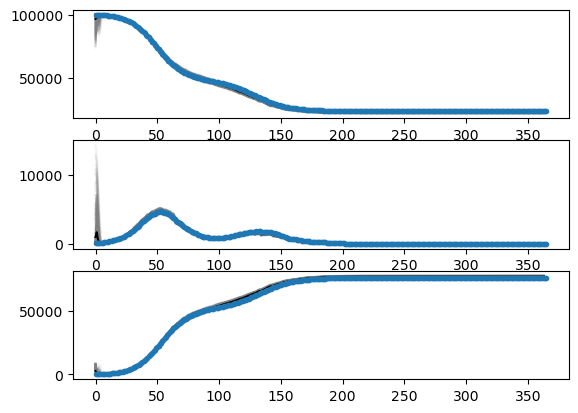

In [17]:
x_lag_list = np.array(x_lag_list)
x_lag_means = np.mean(x_lag_list, axis=2)

fig, ax = plt.subplots(3)
ax[0].plot(x_lag_list[:,0,:], color='gray', alpha=0.1)
ax[0].plot(x_lag_means[:,0], color='black')
ax[0].plot(data.S, '.')

ax[1].plot(x_lag_list[:,1,:], color='gray', alpha=0.1)
ax[1].plot(x_lag_means[:,1], color='black')
ax[1].plot(data.I, '.')

ax[2].plot(x_lag_list[:,2,:], color='gray', alpha=0.1)
ax[2].plot(x_lag_means[:,2], color='black')
ax[2].plot(data.R, '.')

Text(0.5, 0.98, 'EnSRS window size 1')

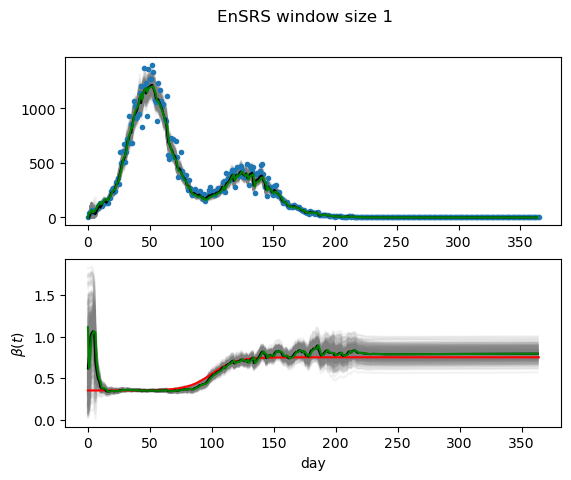

In [18]:
θ_lag_list = np.array(θ_lag_list)

fig, ax = plt.subplots(2)

ax[0].plot(x_lag_list[:,3,:], color='gray', alpha=0.1)
ax[0].plot(data.i, '.')
ax[0].plot(x_lag_means[:,3], color='black')
ax[0].plot(np.mean(x_list[:,3,:], axis=1), color='green')

ax[1].plot(θ_lag_list[:,0,:], color="gray", alpha=0.1)
ax[1].plot(data.construct_beta(data.rt, data.t_I), color="red")
ax[1].plot(np.mean(θ_lag_list[:,0,:], axis=1), color="black")
ax[1].plot(np.mean(θ_list[:,0,:], axis=1)[:-1], color="green")
ax[1].set_xlabel('day')
ax[1].set_ylabel(r'$\beta(t)$')

fig.suptitle(f'EnSRS window size {l}')

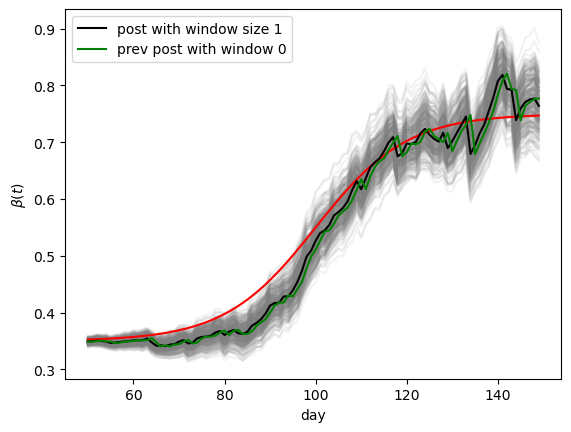

In [19]:
fig, ax = plt.subplots()
tt = np.arange(50, 150)
ens = θ_lag_list[:,0,:]
ax.plot(tt, ens[50:150,:], color="gray", alpha=0.1)
ax.plot(tt, data.construct_beta(data.rt, data.t_I)[50:150], color="red")
ax.plot(tt, np.mean(ens, axis=1)[50:150], color="black", label=f"post with window size {l}")
ax.plot(tt, np.mean(θ_list[:,0,:], axis=1)[50:150], color="green", label=f"prev post with window {l-1}")
ax.set_xlabel('day')
ax.set_ylabel(r'$\beta(t)$')
ax.legend()

In [20]:
print(f"true midpoint: day {np.argmin(np.abs(beta - 0.55))}")
print(f"ensemble midpoint: day {np.argmin(np.abs(np.mean(θ_lag_list[:,0,:], axis=1) - 0.55))}")

true midpoint: day 100
ensemble midpoint: day 103


In [21]:
for l in np.arange(2,10):
    print(l)
    
    θ_list = np.array(θ_lag_list).copy()
    x_list = np.array(x_lag_list).copy()
    
    x_lag_list = []
    θ_lag_list = []

    for k in range(data.n_t-l):
        z = data.i[k+l]
        oev = np.maximum(10, z**2/50)
        H = np.array([0,0,0,1])

        ## Smooth STATES
        x = x_list[k,:,:]
        xhat = xhat_list[k+l,:,:]

        y = H@xhat
        ybar_hat = np.mean(y)
        Pyy = np.cov(y)
        Pb = np.cov(xhat)
        Pba = np.cov(x, xhat)[4:,4:]
        # Pba = (x - np.array([x_bar]).T)@(H@(xhat - np.array([xhat_bar]).T)).T
        # eq 9
        K_lag = (H@Pba).T/(Pyy+oev)

        x_bar = np.mean(x, axis=1)
        xhat_bar = np.array([np.mean(xhat, axis=1)])
        # eq 8
        xbar_lag = x_bar + K_lag*(z - ybar_hat)
        # eq 15
        Ktilde_lag = K_lag/(1. + np.sqrt(oev/(Pyy + oev)))
        # eq 13
        x_lag = (x - np.array([x_bar]).T) + np.array([xbar_lag]).T - Ktilde_lag*H@(xhat - xhat_bar.T)

        x_lag = np.clip(x_lag, 0, data.N)
        x_lag = SIR(*x_lag)
        x_lag_list.append(x_lag)


        ## Smooth PARAMS
        θ = θ_list[k,:,:]
        Pb = np.cov(θ,y)
        H = np.array([0,0,1])
        Pba = np.cov(θ,y)

        # eq 9
        K_lag = (H@Pba).T/(Pyy+oev)
        K_lag = K_lag[:-1]

        θ_bar = np.array([np.mean(θ, axis=1)]).T
        θhat_bar = θ_bar
        # eq 8
        θ_bar_lag = θ_bar + np.array([K_lag*(z - ybar_hat)]).T
        # eq 15
        Ktilde_lag = K_lag/(1. + np.sqrt(oev/(Pyy + oev)))
        # eq 13
        θ_lag = (θ - θ_bar) + θ_bar_lag - np.array([Ktilde_lag]).T@np.array([y - ybar_hat.T])

        θ_lag = np.clip(θ_lag, 0, 10)
        θ_lag = ModelParams(*θ_lag)
        θ_lag_list.append(θ_lag)
    
    print(f"true midpoint: day {np.argmin(np.abs(beta - 0.55))}")
    print(f"ensemble midpoint: day {np.argmin(np.abs(np.mean(np.asarray(θ_lag_list)[:,0,:], axis=1) - 0.55))}")
    


2
true midpoint: day 100
ensemble midpoint: day 102
3
true midpoint: day 100
ensemble midpoint: day 101
4
true midpoint: day 100
ensemble midpoint: day 100
5
true midpoint: day 100
ensemble midpoint: day 99
6
true midpoint: day 100
ensemble midpoint: day 99
7
true midpoint: day 100
ensemble midpoint: day 98
8
true midpoint: day 100
ensemble midpoint: day 98
9
true midpoint: day 100
ensemble midpoint: day 98


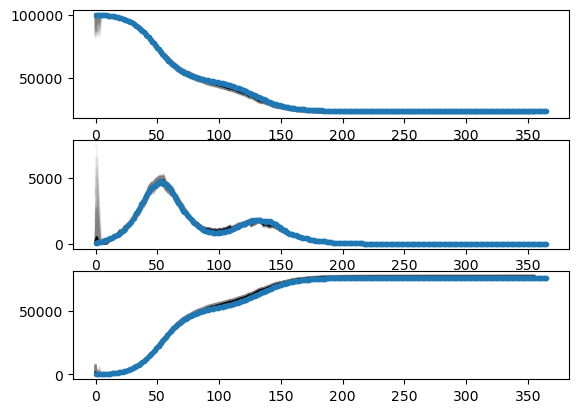

In [22]:
x_lag_list = np.array(x_lag_list)
x_lag_means = np.mean(x_lag_list, axis=2)

fig, ax = plt.subplots(3)
ax[0].plot(x_lag_list[:,0,:], color='gray', alpha=0.1)
ax[0].plot(x_lag_means[:,0], color='black')
ax[0].plot(data.S, '.')

ax[1].plot(x_lag_list[:,1,:], color='gray', alpha=0.1)
ax[1].plot(x_lag_means[:,1], color='black')
ax[1].plot(data.I, '.')

ax[2].plot(x_lag_list[:,2,:], color='gray', alpha=0.1)
ax[2].plot(x_lag_means[:,2], color='black')
ax[2].plot(data.R, '.')

Text(0.5, 0.98, 'EnSRS window size 9')

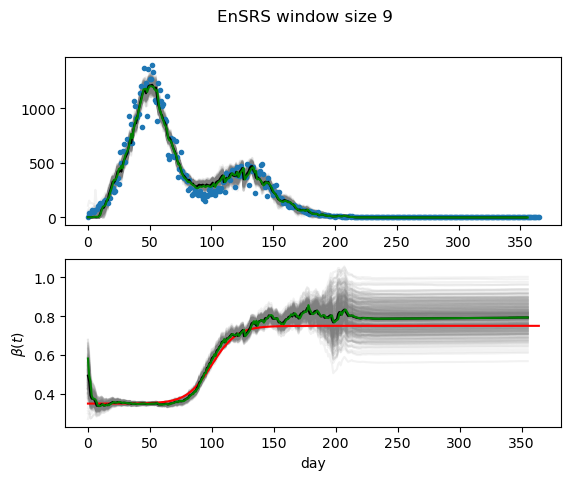

In [23]:
θ_lag_list = np.array(θ_lag_list)

fig, ax = plt.subplots(2)

ax[0].plot(x_lag_list[:,3,:], color='gray', alpha=0.1)
ax[0].plot(data.i, '.')
ax[0].plot(x_lag_means[:,3], color='black')
ax[0].plot(np.mean(x_list[:,3,:], axis=1), color='green')

ax[1].plot(θ_lag_list[:,0,:], color="gray", alpha=0.1)
ax[1].plot(data.construct_beta(data.rt, data.t_I), color="red")
ax[1].plot(np.mean(θ_lag_list[:,0,:], axis=1), color="black")
ax[1].plot(np.mean(θ_list[:,0,:], axis=1)[:-1], color="green")
ax[1].set_xlabel('day')
ax[1].set_ylabel(r'$\beta(t)$')

fig.suptitle(f'EnSRS window size {l}')

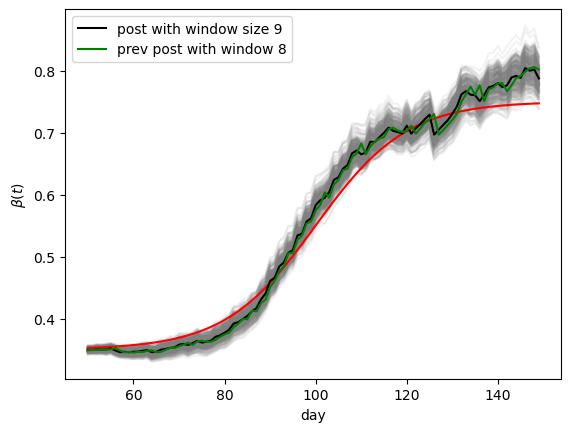

In [24]:
fig, ax = plt.subplots()
tt = np.arange(50, 150)
ens = θ_lag_list[:,0,:]
ax.plot(tt, ens[50:150,:], color="gray", alpha=0.1)
ax.plot(tt, data.construct_beta(data.rt, data.t_I)[50:150], color="red")
ax.plot(tt, np.mean(ens, axis=1)[50:150], color="black", label=f"post with window size {l}")
ax.plot(tt, np.mean(θ_list[:,0,:], axis=1)[50:150], color="green", label=f"prev post with window {l-1}")
ax.set_xlabel('day')
ax.set_ylabel(r'$\beta(t)$')
ax.legend()

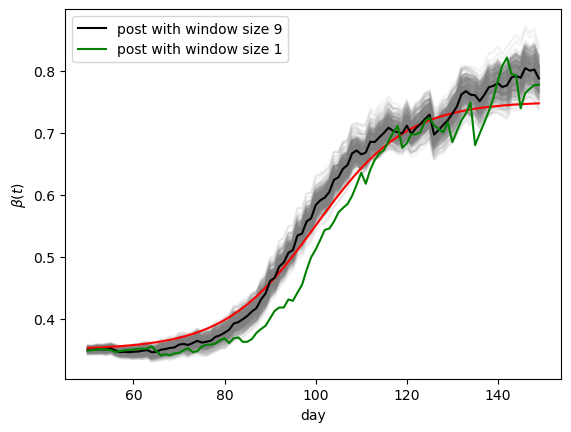

In [25]:
fig, ax = plt.subplots()
tt = np.arange(50, 150)
ens = θ_lag_list[:,0,:]
ax.plot(tt, ens[50:150,:], color="gray", alpha=0.1)
ax.plot(tt, data.construct_beta(data.rt, data.t_I)[50:150], color="red")
ax.plot(tt, np.mean(ens, axis=1)[50:150], color="black", label=f"post with window size {l}")
ax.plot(tt, np.mean(first_θ_list[:,0,:], axis=1)[50:150], color="green", label=f"post with window size 1")
ax.set_xlabel('day')
ax.set_ylabel(r'$\beta(t)$')
ax.legend()

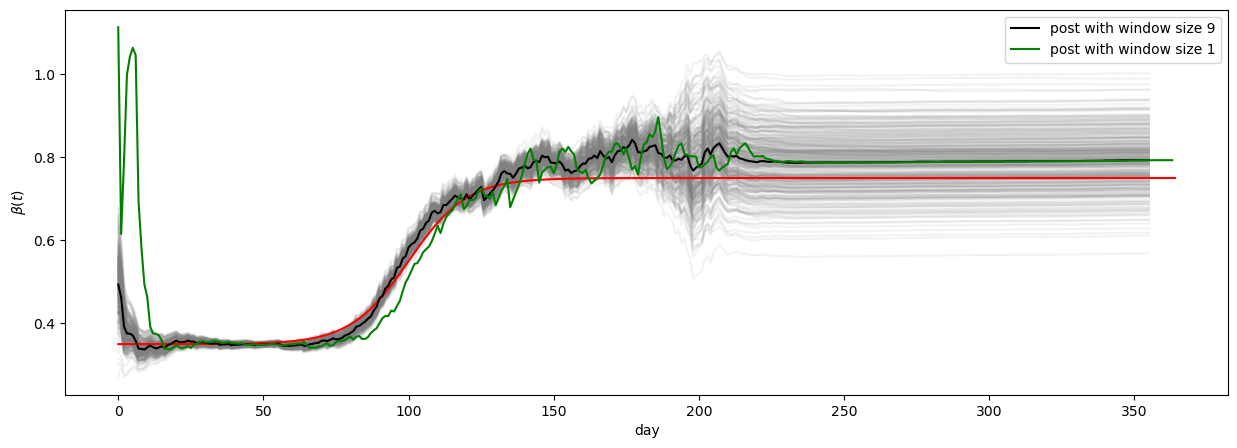

In [26]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(θ_lag_list[:,0,:], color="gray", alpha=0.1)
ax.plot(data.construct_beta(data.rt, data.t_I), color="red")
ax.plot(np.mean(θ_lag_list[:,0,:], axis=1), color="black", label=f"post with window size {l}")
ax.plot(np.mean(first_θ_list[:,0,:], axis=1)[:-1], color="green", label=f"post with window size 1")
ax.set_xlabel('day')
ax.set_ylabel(r'$\beta(t)$')
ax.legend()

In [27]:
θ_lag_list.shape

(356, 2, 300)

In [28]:
ints = np.random.randint(0,300, size=1000)

In [29]:
draws = θ_lag_list[:,0,ints]

In [30]:
def free_simulation(beta):
    S = np.array([data.S0])
    Ir = np.array([data.I0])
    R = np.array([0])
    i = np.array([0])
    for t in range(data.n_t-20):
        dSI = np.random.poisson(beta[t]*Ir[t]*S[t]/data.N)
        dIR = np.random.poisson(Ir[t]/data.t_I)

        S_new = np.clip(S[t]-dSI, 0, data.N)
        I_new = np.clip(Ir[t]+dSI-dIR, 0, data.N)
        R_new = np.clip(R[t]+dIR, 0, data.N)

        S = np.append(S, S_new)
        Ir = np.append(Ir, I_new)
        R = np.append(R, R_new)
        i = np.append(i, dSI)

    i_true = i
    
    return S, Ir, R, i

In [31]:
S, Ir, R, i = np.apply_along_axis(free_simulation, axis=0, arr=draws)

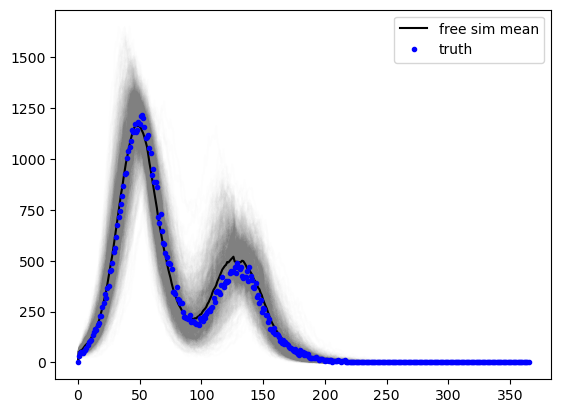

In [32]:
fig, ax = plt.subplots()
ax.plot(i, color="gray", alpha=0.01)
ax.plot(np.mean(i, axis=1), color="black", label="free sim mean")
ax.plot(data.i_true, '.', color='blue', label="truth")
ax.legend()

In [33]:
first_draws = first_θ_list[20:,0,ints]

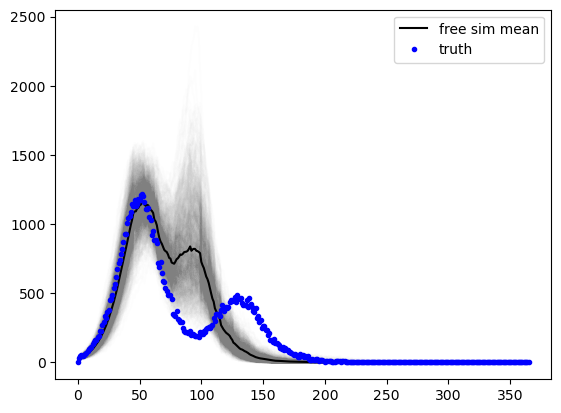

In [34]:
S, Ir, R, i = np.apply_along_axis(free_simulation, axis=0, arr=first_draws)
fig, ax = plt.subplots()
ax.plot(i, color="gray", alpha=0.01)
ax.plot(np.mean(i, axis=1), color="black", label="free sim mean")
ax.plot(data.i_true, '.', color='blue', label="truth")
ax.legend()

In [35]:
first_θ_list.shape

(365, 2, 300)

# EnKS

In [39]:
from enks import EnsembleKalmanSmoother

In [40]:
EnsembleKalmanSmoother(f, h, Q=None, R, init_mean, init_cov, N=300)

def h(x):
    """
    Observational function.
        Args:
            x: state space
            α: report rate
    """
    return x.i

def f0(pop, m=300):
    """
    Initial guess of the state space.
        Args:
            pop: population
            m: number of ensemble members
    """

    S0 = np.random.uniform(pop*0.8, pop, size=m)
    I0 = pop - S0
    R0 = np.zeros(m)
    i0 = np.zeros(m)
    
    x0 = SIR(
        S = S0,
        I = I0,
        R = R0,
        i = i0
    )
    return x0

def θ0(prior, m=300):
    """
    Initial guess of the parameter space.
        Args:
            prior: prior
            m: number of ensemble members
    """
    beta = prior['beta']['dist'](**prior['beta']['args'], size=m)
    θ0 = ModelParams(beta=beta, t_I=np.ones(m)*data.t_I)
    return θ0

enks.EnsembleKalmanSmoother

In [52]:
x0 = f0(data.N)
np.mean(x0, axis=1)
np.cov(x0)

array([[ 34810627.10767052, -34810627.1076705 ,         0.        ,
                0.        ],
       [-34810627.1076705 ,  34810627.10767051,         0.        ,
                0.        ],
       [        0.        ,         0.        ,         0.        ,
                0.        ],
       [        0.        ,         0.        ,         0.        ,
                0.        ]])